In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!nvidia-smi

Tue Aug 17 14:23:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 64.8 MB/s 
     |████████████████████████████████| 895 kB 58.3 MB/s 
     |████████████████████████████████| 636 kB 83.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!pip install pytorch-lightning

     |████████████████████████████████| 916 kB 4.3 MB/s 
     |████████████████████████████████| 118 kB 91.5 MB/s 
     |████████████████████████████████| 829 kB 84.1 MB/s 
     |████████████████████████████████| 272 kB 68.6 MB/s 
     |████████████████████████████████| 1.3 MB 66.9 MB/s 
     |████████████████████████████████| 142 kB 92.7 MB/s 
     |████████████████████████████████| 294 kB 69.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=0383a880a45f7f867ec75c4243f066d241856f1fe878ab362195ad0af49ec286
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [7]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from imblearn.over_sampling import SMOTE

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [8]:
# import dataset
df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/preprocessed_version1.csv')
df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,December 2019 new highly contagious infectious...,0,0,0,1,0,0,1
1,"novel coronavirus disease COVID-19 , transmitt...",0,0,0,0,1,0,1
2,BACKGROUND December 2019 novel coronavirus SAR...,1,0,0,0,0,0,0
3,coronavirus disease 2019 COVID-19 pandemic imp...,0,0,0,0,1,0,0
4,OBJECTIVES Sofosbuvir daclatasvir direct-actin...,0,0,0,0,0,0,1


In [9]:
# preprocess dataset
# df = df.drop(['pmid',	'journal',	'title', 'doi',	'label', 'keywords', 'pub_type', 'authors'], axis=1)
# df.head()
# drop none value
df = df.dropna()
df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,December 2019 new highly contagious infectious...,0,0,0,1,0,0,1
1,"novel coronavirus disease COVID-19 , transmitt...",0,0,0,0,1,0,1
2,BACKGROUND December 2019 novel coronavirus SAR...,1,0,0,0,0,0,0
3,coronavirus disease 2019 COVID-19 pandemic imp...,0,0,0,0,1,0,0
4,OBJECTIVES Sofosbuvir daclatasvir direct-actin...,0,0,0,0,0,0,1


In [10]:
# df = df.drop(["Epidemic Forecasting", "Transmission"], axis=1)
# df.shape

In [11]:
train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((22461, 8), (2496, 8))

In [12]:
LABEL_COLUMNS = df.columns.tolist()[1:]

In [13]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [14]:
df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting      645
Transmission             1088
Case Report              2063
Mechanism                4437
Diagnosis                6193
Treatment                8716
Prevention              11101
dtype: int64

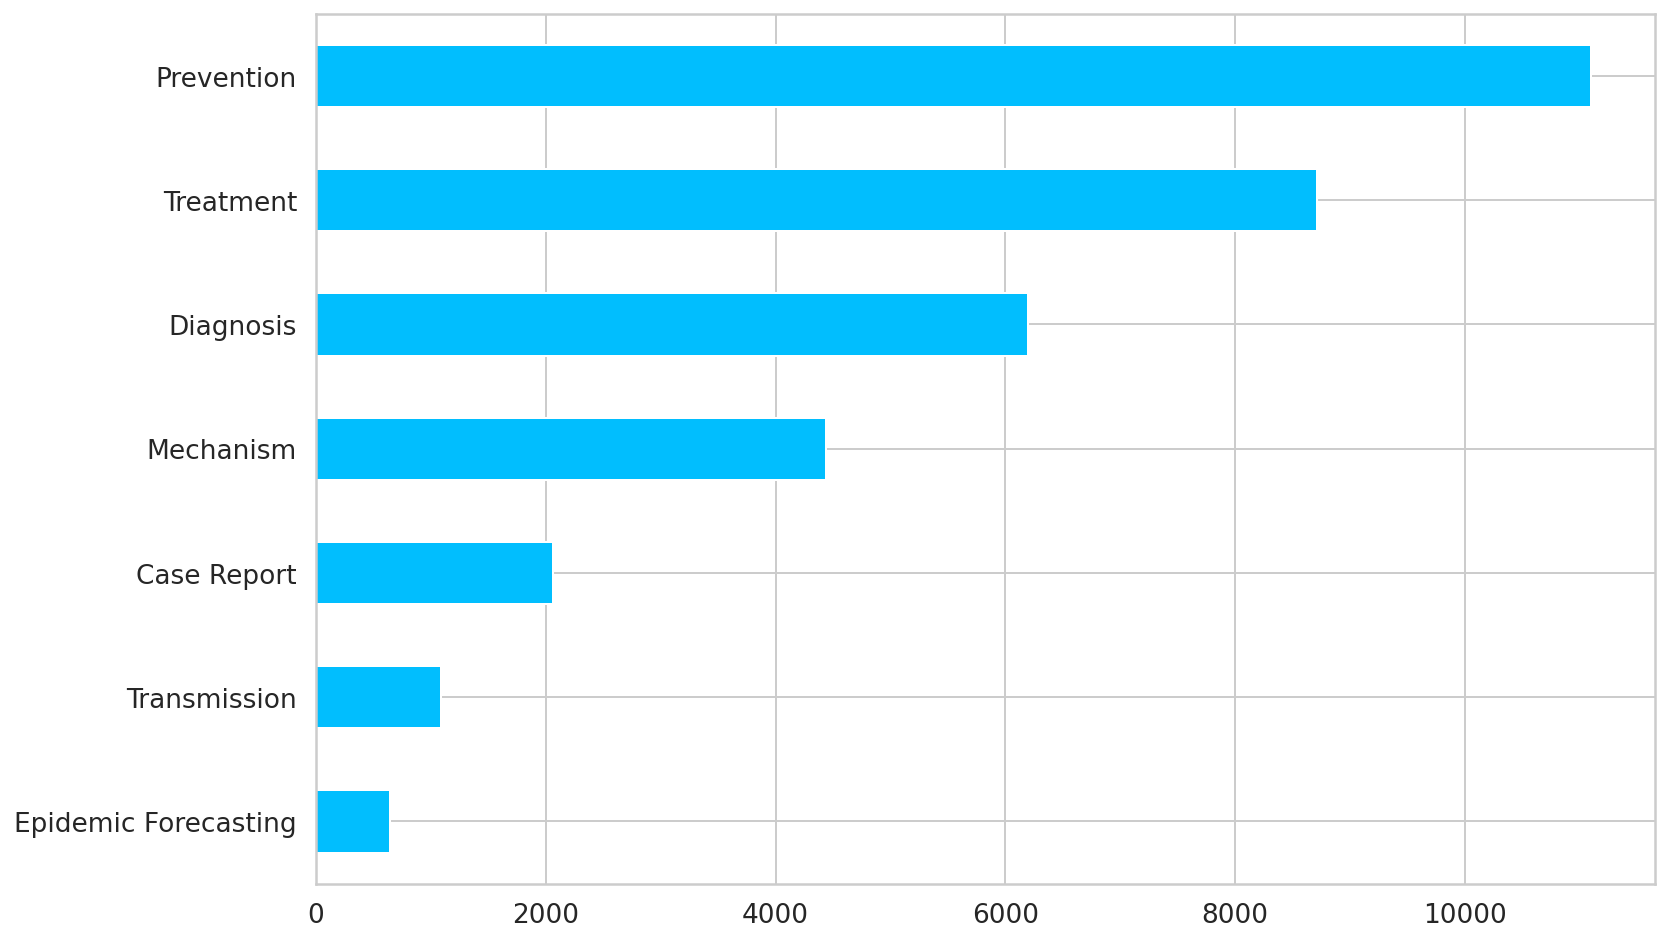

In [31]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### simple oversampling, doubling minority classes

In [42]:
ef_true = train_df[train_df["Epidemic Forecasting"] == 1]
len(ef_true)

581

In [43]:
tr_true = train_df[train_df["Transmission"] == 1]
len(tr_true)

985

In [44]:
ef_true = pd.concat([ef_true, ef_true, ef_true], axis=0)
ef_true.shape

(1743, 8)

In [45]:
tr_true = pd.concat([tr_true, tr_true], axis=0)
tr_true.shape

(1970, 8)

In [52]:
Train_df = train_df[train_df["Epidemic Forecasting"] != 1]
Train_df = Train_df[train_df["Transmission"] != 1]
Train_df.shape 

(20951, 8)

In [47]:
train_df.shape

(22461, 8)

In [53]:
train_df = pd.concat([Train_df, ef_true, tr_true], axis=0)
train_df.shape

(24664, 8)

In [55]:
train_df[LABEL_COLUMNS].sum().sort_values()

Case Report              1847
Epidemic Forecasting     1855
Transmission             2138
Mechanism                4266
Diagnosis                5857
Treatment                7952
Prevention              11348
dtype: int64

In [56]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.shape

(24664, 8)

### continuation

In [15]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [16]:
MAX_TOKEN_COUNT = 512

In [17]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [18]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [19]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [20]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [21]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, input_ids, attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # last_hidden_state (batch_size x sequence_length x hidden_size)
    encoded_output = bert_outputs.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(encoded_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))

    # output = self.classifier(output.pooler_output)
    # output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [22]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [23]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(2806, 14030)

In [24]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
%pwd

'/content'

In [26]:
cd '/content/drive/MyDrive/Biocreative/Biocreative'

/content/drive/MyDrive/Biocreative/Biocreative


In [71]:
checkpoint_callback = ModelCheckpoint(
    dirpath="pubmednlp-lwan-checkpoints(oversampled)",
    filename="pubmednlp-lwan-best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [72]:
logger = TensorBoardLogger("pubmednlp-lwan-lightning_logs(oversampled)", name="topic-annotations")

In [73]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [74]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

### Test

In [106]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint.ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
trained_model.freeze()

### Load Dev data

In [112]:
dev_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/preprocessed_dev_version1.csv")
dev_df = dev_df.dropna()
dev_df.head()

,Unnamed: 0,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,0,Studies shown infection excessive coagulation ...,0,0,0,0,0,0,1
1,1,BACKGROUND Emergence coronavirus disease COVID...,0,0,1,0,1,0,0
2,2,Four decade neoliberal health policy left Unit...,0,0,0,0,1,0,0
3,3,global SARSCoV2 pandemic started late 2019 cur...,0,0,0,1,0,0,1
4,4,current coronavirus pandemic ongoing global he...,0,0,0,1,0,0,1


### Evaluation

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

dev_dataset = TopicAnnotationDataset(
    dev_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [114]:
predictions = []
labels = []

for item in tqdm(dev_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)    
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/6237 [00:00<?, ?it/s]

#### Accuracy

In [115]:
THRESHOLD = 0.9

In [116]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9305)

#### ROC for each tag

In [117]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9878703355789185
Diagnosis: 0.9728286266326904
Epidemic Forecasting: 0.9828163385391235
Mechanism: 0.9845589995384216
Prevention: 0.9872716665267944
Transmission: 0.9663785099983215
Treatment: 0.9732075929641724


#### classification report for each class

In [118]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report       0.91      0.84      0.87       482
           Diagnosis       0.97      0.53      0.68      1546
Epidemic Forecasting       1.00      0.01      0.01       192
           Mechanism       0.96      0.66      0.78      1073
          Prevention       0.98      0.85      0.91      2748
        Transmission       1.00      0.05      0.10       256
           Treatment       0.97      0.63      0.76      2207

           micro avg       0.97      0.67      0.79      8504
           macro avg       0.97      0.51      0.59      8504
        weighted avg       0.97      0.67      0.77      8504
         samples avg       0.80      0.73      0.75      8504



Preprocessing dev set

In [48]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [86]:
def remove_waste_words(text):

  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
  new_list = []
  for element in filtered_sentence:
    new_list.append(lemmatizer.lemmatize(element))

  new_text = ' '.join(new_list)

  for element in new_text:
    if element in punc:
      new_text = new_text.replace(element, "")
  sample_text = new_text

  text_ = ' '.join(sample_text.split())

  return text_

In [91]:
dev_df = pd.read_csv('/content/drive/MyDrive/Biocreative/Biocreative/datasets/preprocessed_dev.csv')
dev_df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,"Studies have shown that infection, excessive c...",0,0,0,0,0,0,1
1,BACKGROUND: Emergence of the coronavirus disea...,0,0,1,0,1,0,0
2,Four decades of neoliberal health policies hav...,0,0,0,0,1,0,0
3,The global SARS-CoV-2 pandemic started late 20...,0,0,0,1,0,0,1
4,The current coronavirus pandemic is an ongoing...,0,0,0,1,0,0,1


In [92]:
DF = dev_df['abstract'].apply(remove_waste_words)

In [100]:
labels = dev_df[dev_df.columns[1:]]
labels.shape, DF.shape

((6239, 7), (6239,))

In [103]:
df = pd.concat([DF, labels], axis=1)
df.shape

(6239, 8)

In [104]:
df

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Studies shown infection excessive coagulation ...,0,0,0,0,0,0,1
1,BACKGROUND Emergence coronavirus disease COVID...,0,0,1,0,1,0,0
2,Four decade neoliberal health policy left Unit...,0,0,0,0,1,0,0
3,global SARSCoV2 pandemic started late 2019 cur...,0,0,0,1,0,0,1
4,current coronavirus pandemic ongoing global he...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
6234,ongoing coronavirus disease 2019 COVID19 crisi...,0,0,0,0,1,0,0
6235,novel SARSCoV2 coronavirus attracted attention...,0,0,0,1,0,1,0
6236,BACKGROUND novel coronavirus disease 2019 COVI...,0,0,0,0,0,0,1
6237,Resuming procedural sedation service elective ...,0,0,0,0,1,0,0


In [105]:
df.to_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/preprocessed_dev_version1.csv")